In [1]:
import plotting
import tools
import event_identification
import preprocess_timeseries
from importlib import reload
import numpy as np
import xarray as xr
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import colors

import matplotlib.gridspec as gridspec
import seaborn as sns
import scienceplots
import cartopy as cart

from datetime import datetime

import gsw

import h3
from h3.unstable import vect

import sys
import pickle
from collections import deque
import tqdm

%config InlineBackend.figure_format = 'retina'

sys.path.append('/nethome/4302001/NASTMW/tools')


/nethome/4302001/miniconda3/lib/python3.9/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
traj_dir = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_trajectories/"
event_dir = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_events_timescales_yearly/"
mask_dir = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_trajectory_masks/"
aggregated_dir = "/nethome/4302001/output_data/EDW_events_aggregated/"

In [3]:
experiments = [
    "stay_in_edw_1y",
    "reached_mixing_back_in_edw",
    "densification_001_1y_after_2y",
    "subduction_after_1y",
    ## above represent the most important ones
    # "reached_mixing",
    # "densification_005_1y_after_2y",
    # "densification_005_1y_after_3y",
    # "densification_001_1y_after_3y",
    # "densification_0_1y_after_2y",
    # "densification_0_1y_after_3y",
    # "reached_mixed",
    # "reached_mixed_back_in_edw",
    # "reached_mixed_not_in_edw",
    # "return_to_edw_1y",
    # "reached_mixing_not_in_edw",
    # "subduction_after_2y",
    # "subduction_after_3y"
]

In [4]:
aggregated_events_experiments = {}
for experiment in experiments:
    sign = "-" if "subduction" in experiment else ""
    with open(aggregated_dir + f"EDW_wfluxes_B_1095d_dt{sign}90_odt24_{experiment}_aggregated_events_per_year_rw10.pkl", "rb" ) as input_file:
        aggregated_events_experiments[experiment] = pickle.load(input_file)

In [54]:
days_per_month = np.roll(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), -8)
days_per_month_reverse = days_per_month[::-1]

month_bins = np.zeros(13, dtype=int)
month_bins[1:] = np.cumsum(days_per_month_reverse)

month_bins_reverse = np.zeros(13, dtype=int)
month_bins_reverse[1:] = np.cumsum(days_per_month_reverse)

labels_forwards = np.roll(np.array(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct","Nov", "Dec"]), -8)
labels_backwards = labels_forwards[::-1]

# Persistence

In [55]:
# check agreement between figure distributions and aggregated events
total = 0
for year in np.arange(1995, 2016):
    total += np.sum(aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']['durations'] <= 10)
print(total)
print(2296147)

2296147
2296147


In [56]:
duration_bins = np.concatenate([np.arange(0, 101, 10), [np.inf]])
duration_bins_edges = np.stack([duration_bins[:-1], duration_bins[1:]], axis=1)

In [59]:
low_outlier_start_month = {year : {} for year in range(1995, 2016)}
high_outlier_start_month = {year : {} for year in range(1995, 2016)}
for year in range(1995, 2016):
    for bindex, edges in enumerate(duration_bins_edges):
        mask = (aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']['durations'] > edges[0])*\
               (aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']['durations'] <= edges[1])
        Q75 = np.quantile(aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']["magnitudes"][mask], 0.75)
        Q25 = np.quantile(aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']["magnitudes"][mask], 0.25)
        IQR = Q75 - Q25
        low_outliers_idx = (aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']["magnitudes"][mask] < (Q25 - 1.5 * IQR))
        high_outliers_idx = (aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']["magnitudes"][mask] > (Q75 + 1.5 * IQR))
        low_outlier_start_month[year][bindex] = np.histogram(aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']["index_start"][mask][low_outliers_idx], bins=month_bins)[0]
        high_outlier_start_month[year][bindex] = np.histogram(aggregated_events_experiments["stay_in_edw_1y"][year]['cs_DIC_total']["index_start"][mask][high_outliers_idx], bins=month_bins)[0]

In [60]:
low_outlier_start_month_allyears  = {bindex : np.sum([low_outlier_start_month[year][bindex] for year in range(1995, 2016)], axis=0) for bindex in range(len(duration_bins_edges))}

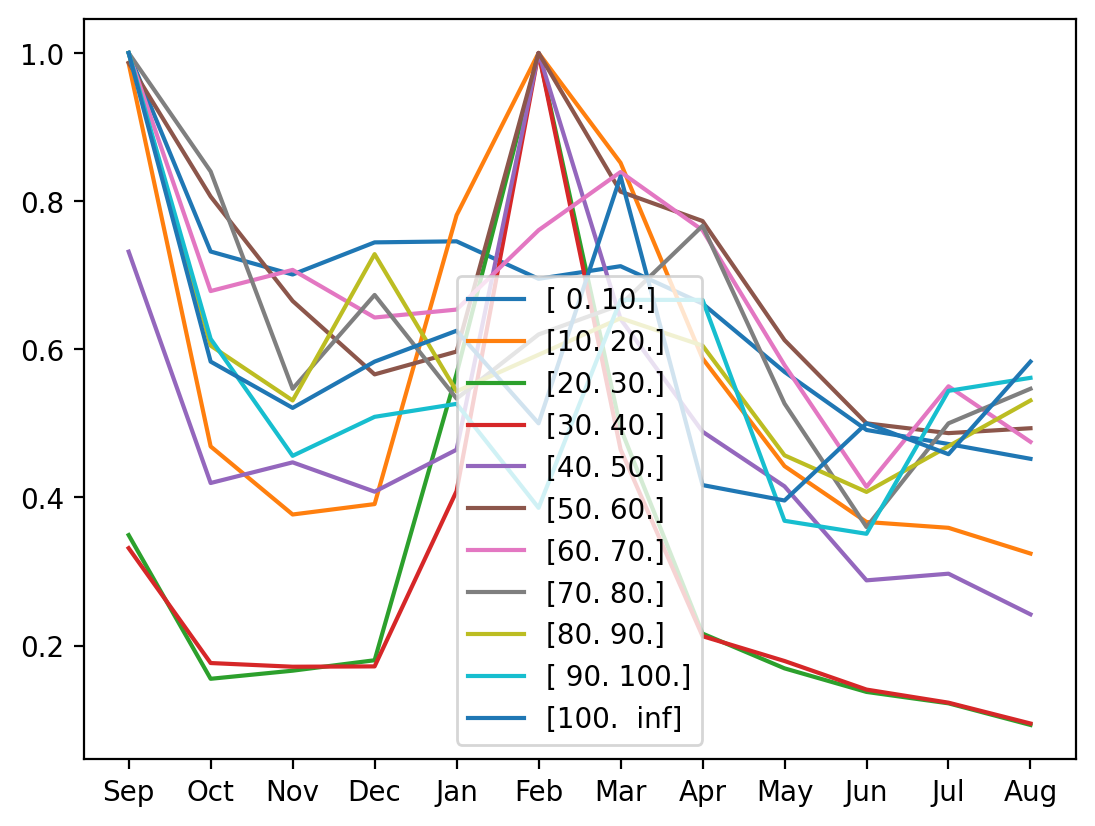

In [61]:
for i, edges in enumerate(duration_bins_edges):
    plt.plot(labels_forwards, low_outlier_start_month_allyears[i]/low_outlier_start_month_allyears[i].max(), label=f"{duration_bins_edges[i]}")
plt.legend()

# Subduction

In [63]:
low_values_start_month = {year : {} for year in range(1995, 2016)}
high_values_start_month = {year : {} for year in range(1995, 2016)}
for year in range(1995, 2016):
    for bindex, edges in enumerate(duration_bins_edges):
        mask = (aggregated_events_experiments["subduction_after_1y"][year]['cs_DIC_total']['durations'] > edges[0])*\
               (aggregated_events_experiments["subduction_after_1y"][year]['cs_DIC_total']['durations'] <= edges[1])
        Q75 = np.quantile(aggregated_events_experiments["subduction_after_1y"][year]['cs_DIC_total']["magnitudes"][mask], 0.75)
        Q25 = np.quantile(aggregated_events_experiments["subduction_after_1y"][year]['cs_DIC_total']["magnitudes"][mask], 0.25)
        IQR = Q75 - Q25
        low_values_idx = (aggregated_events_experiments["subduction_after_1y"][year]['cs_DIC_total']["magnitudes"][mask] < (Q25 - 1.5 * IQR))
        high_values_idx = (aggregated_events_experiments["subduction_after_1y"][year]['cs_DIC_total']["magnitudes"][mask] > (Q75 + 1.5 * IQR))
        low_values_start_month[year][bindex] = np.histogram(aggregated_events_experiments["subduction_after_1y"][year]['cs_DIC_total']["index_start"][mask][low_values_idx], bins=month_bins_reverse)[0]
        high_values_start_month[year][bindex] = np.histogram(aggregated_events_experiments["subduction_after_1y"][year]['cs_DIC_total']["index_start"][mask][high_values_idx], bins=month_bins_reverse)[0]
low_values_start_month_allyears  = {bindex : np.sum([low_values_start_month[year][bindex] for year in range(1995, 2016)], axis=0) for bindex in range(len(duration_bins_edges))}

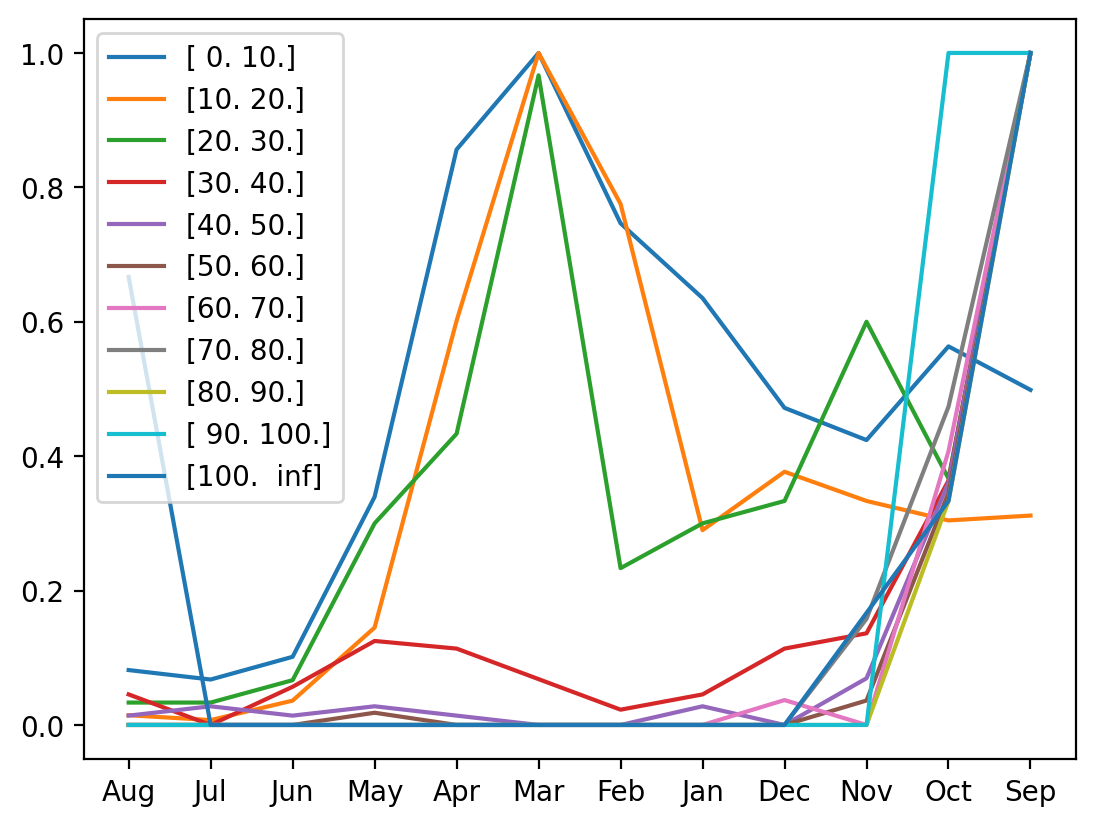

In [64]:
fig, ax = plt.subplots()
for i, edges in enumerate(duration_bins_edges):
    ax.plot(labels_backwards, low_values_start_month_allyears[i]/low_values_start_month_allyears[i].max(), label=f"{duration_bins_edges[i]}")
# set logaritmic scale
# ax.set_yscale('log')
ax.legend()